In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import ferel
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# Generate toy data sampled uniformly from a cube.
X, y, normal, b = ferel.toy_data_generation.gen_toy_data_uniform(
    n_samples=5000, n_str_rel=4, n_weak_rel=4, n_irrel=4)

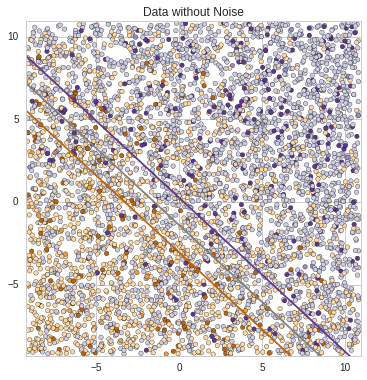

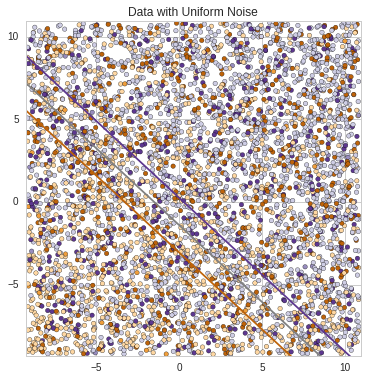

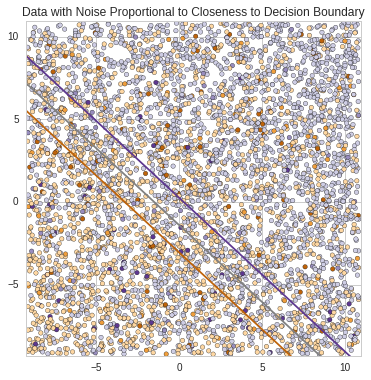

In [69]:
# Plot toy data using one of our special plotting functions.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, normal, b)
ax.set_title('Data without Noise')

y_with_noise_1 = ferel.toy_data_generation.add_label_noise_uniform(y, 0.2)
ax = ferel.plotting.scatter_2d_hyperplane(X, y_with_noise_1, 0, 1, normal, b)
ax.set_title('Data with Uniform Noise')

y_with_noise_2 = ferel.toy_data_generation.add_label_noise_border(X, y, normal, b, 0.2)
ax = ferel.plotting.scatter_2d_hyperplane(X, y_with_noise_2, 0, 1, normal, b)
ax.set_title('Data with Noise Proportional to Closeness to Decision Boundary');

X = ferel.toy_data_generation.add_data_noise_gaussian(X, 0.1)

In [70]:
# Perform a z-score transformation on the data ( X_scaled = (X - mean(X))/std(X) )
X = X - np.mean(X)
scaling = np.std(X,0)
X = X / scaling
normal = normal * scaling

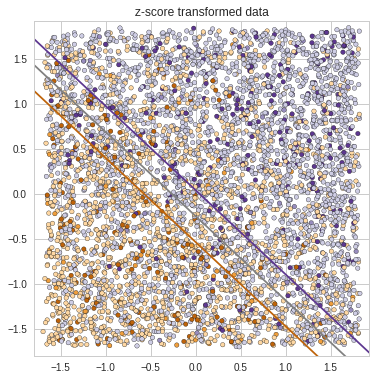

In [71]:
# Plot again.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, normal, b)
ax.set_title('z-score transformed data')

[ -3.46440866e-01  -3.72425155e-01   2.12897666e-01  -6.16731943e-01
   2.23664863e-02   3.28366796e-01  -1.84834060e-01  -4.16013228e-01
  -1.11608816e-03  -1.13287314e-03  -6.02183100e-03  -2.92464326e-04]
[-0.35149897 -0.37451664  0.21915211 -0.62565427  0.03781788  0.31728258
 -0.24334416 -0.36795445 -0.00146566 -0.00102633 -0.00242328  0.00069487]


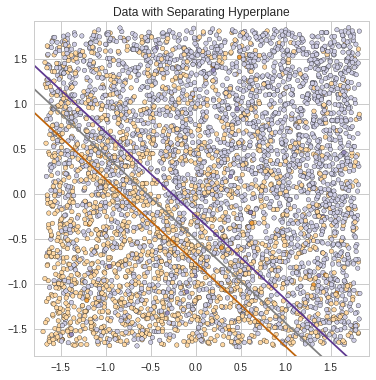

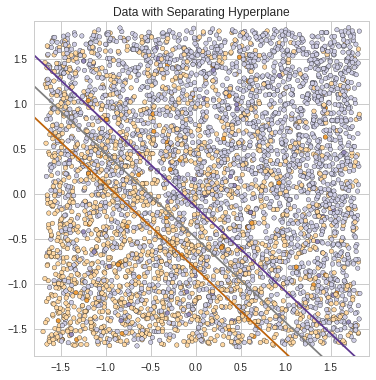

In [76]:
C = 1
hyp, offset, slack, C = ferel.ferel.find_hyp_l1(X, y, C=C)

# Plot data together with the determined separating hyperplane.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, hyp, offset)
ax.set_title('Data with Separating Hyperplane');

print(hyp / np.linalg.norm(hyp))


from sklearn import svm
clf = svm.LinearSVC(penalty='l1', C=C, loss='squared_hinge', dual=False)
clf.fit(X, y)
hyp2 = np.ndarray.flatten(clf.coef_.T)
offset2 = - clf.intercept_

print(hyp2 / np.linalg.norm(hyp2))

ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, hyp2, offset2)
ax.set_title('Data with Separating Hyperplane');

In [73]:
print(type(hyp), hyp.shape, type(hyp2), hyp2.shape)

<class 'numpy.ndarray'> (12,) <class 'numpy.ndarray'> (12,)


In [29]:
type(slack)

numpy.matrixlib.defmatrix.matrix

In [30]:
# Find seperating hyperplane.
hyp2, offset2, slack2, acc, C = ferel.ferel.find_hyp_ridge(X, y, C=0.1)

# Plot data together with the determined separating hyperplane.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, hyp, offset)
ax.set_title('Data with Separating Hyperplane');

IndexError: index 1 is out of bounds for axis 0 with size 1

In [7]:
# Investigate found separating hyperplane
print(
    'Found hyperplane has {} intrusions from label 1 and {} intrusions from label -1. \n \
Slack variable losses sum to {} and {}, respectively. \n \
The accuracy on the training data is {} with {} misclassifications.'.format(
        np.count_nonzero(y[np.logical_and(y == 1, slack > 0)]),
        np.count_nonzero(y[np.logical_and(y == -1, slack > 0)]),
        np.sum(slack[y == 1]),
        np.sum(slack[y == -1]), acc, np.count_nonzero(slack[slack > 1])))

Found hyperplane has 113 intrusions from label 1 and 125 intrusions from label -1. 
 Slack variable losses sum to 20.353925830012003 and 18.247874352922683, respectively. 
 The accuracy on the training data is 1.0 with 0 misclassifications.


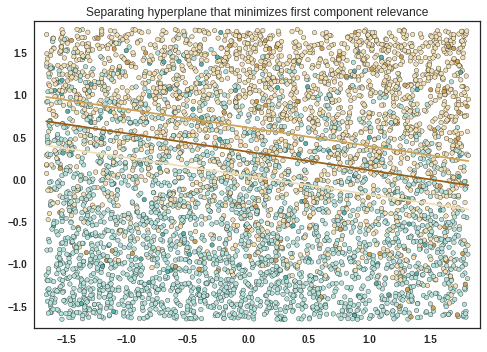

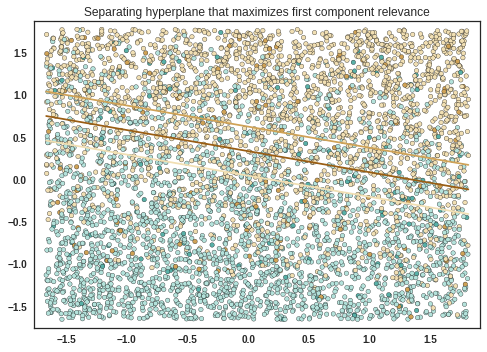

In [8]:
# Calculate relevance bounds.
omega, xp, b = ferel.ferel.find_relevances(X, y, hyp, offset, slack, C)

# Plot the hyperplanes for dimension 1 found by the optimization problems.
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, omega[:,0], b[0])
ax.set_title('Separating hyperplane that minimizes first component relevance')
ax = ferel.plotting.scatter_2d_hyperplane(X, y, 0, 1, omega[:,1], b[1])
ax.set_title('Separating hyperplane that maximizes first component relevance')

In [9]:
n_iter = 5
(n, d) = X.shape
shadows = np.zeros((n_iter, 2 * d))

for i in range(n_iter):
    # Calculate shadow relevance bounds
    shadows[i, :] = ferel.ferel.find_shadow_relevances(X, y, hyp, offset, slack, C)
print('Over {} iterations, found mean shadow relevance vector \n{}\n with std \n{}.'.
      format(n_iter, np.mean(shadows, 0), np.std(shadows,0)))

# Correct relevances by those found by shadow features
xp[1::2] = np.maximum(0, xp[1::2] - np.mean(shadows, 0)[1::2])
# Set extremely small relevances values to zero
eps = 1e-10
xp[xp < eps] = 0

Over 5 iterations, found mean shadow relevance vector 
[  4.47861231e-13   3.95738491e-02   1.84998037e-13   5.17780809e-02
   1.00740453e-12   4.72931955e-02   3.08970179e-12   4.31816825e-02
   1.31281686e-12   4.16927941e-02   3.29589738e-13   3.81947078e-02]
 with std 
[  3.69637006e-13   4.87610611e-03   1.83401229e-13   9.43982941e-03
   1.21529660e-12   1.11984960e-02   3.00800067e-12   1.02343380e-02
   1.88768024e-12   5.01814276e-03   2.75282797e-13   5.53595927e-03]
.


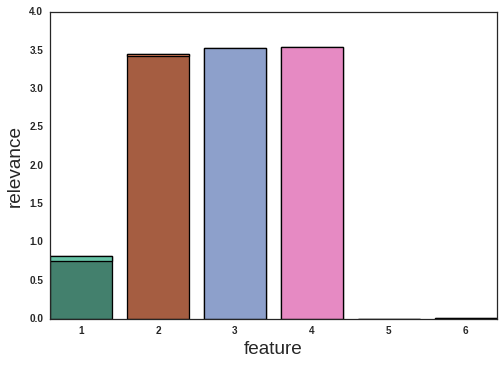

In [12]:
stacked = np.transpose(np.vstack((xp[1::2], xp[0::2])))
# Visualize feature relevances
ax = ferel.plotting.plot_intervals(stacked)